In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part1.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own group**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Question 0: Basic Time Series Modeling

We will introduce a few basic modeling techniques using temporally correlated data that you are free to adapt or improve throughout your modeling process if you wish. Answer these questions in their respective cells below.

### Question 0a
Suppose $\tilde{x} = [1, x_{t}]$ represents the input to a machine learning function $f_\theta: \mathbb{R}^{2} \rightarrow \mathbb{R}$, and we wish to predict $x_{t + 1}$ such that $f_\theta(\tilde{x}) \approx x_{t+1}$. You may assume that $t = 0$ corresponds to the start of time. 

<!-- BEGIN QUESTION -->

i) Is this an example of supervised or unsupervised learning?
<!--
BEGIN QUESTION
name: q0ai
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

ii) Write the function $x_{t+1}$ explicitly in terms of the model parameters $\theta = [\theta_0, \theta_1]$ and $x_t$ assuming $f$ represents a linear model.
<!--
BEGIN QUESTION
name: q0aii
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iii) Suppose we obtain an optimal $\hat{\theta} = [\hat{\theta}_0, \hat{\theta}_1]$. Derive $x_{t+1}$ in terms of $x_0$, $\hat{\theta}_0$ and $\hat{\theta}_1$.

<!--
BEGIN QUESTION
name: q0aiii
points: 4
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iv) Suppose we add $k - 1$ more features such that our feature vector $\tilde{x}$ contains $k$ timesteps of past and current data. Describe how we could select an appropriate $k$.

<!--
BEGIN QUESTION
name: q0aiv
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 1: Data Cleaning

### Question 1a

Investigate the number of missing or null values in `cases` and `vaccinations`. Which one column contains the *most* null values from both of these tables?

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [3]:
max(cases.isna().sum()), max(vaccinations.isna().sum())

(10, 3020)

In [4]:
# use argmax() to get the index of the maximum value
most_null_value_col = vaccinations.columns[vaccinations.isna().sum().argmax()]
most_null_value_col

'People_Partially_Vaccinated'

In [5]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [6]:
nan_indices = cases.columns[cases.isna().any()]
cases[nan_indices].head()      # FIPS -> 0; Admin2 -> ''

,FIPS,Admin2
0,1001.0,Autauga
1,1003.0,Baldwin
2,1005.0,Barbour
3,1007.0,Bibb
4,1009.0,Blount


In [7]:
nan_indices = vaccinations.columns[vaccinations.isna().any()]
vaccinations[nan_indices].tail()        # all -> 0

,FIPS,Lat,Long_,People_Fully_Vaccinated,People_Partially_Vaccinated
17746,56.0,42.756,-107.3025,236785.0,40039.0
17747,56.0,42.756,-107.3025,237374.0,40011.0
17748,56.0,42.756,-107.3025,237495.0,40023.0
17749,56.0,42.756,-107.3025,238024.0,40002.0
17750,56.0,42.756,-107.3025,238199.0,39877.0


In [8]:
cases['FIPS'] = cases['FIPS'].fillna(0)
cases['Admin2'] = cases['Admin2'].fillna('')
vaccinations = vaccinations.fillna(0)

In [9]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c

Add a column to `cases` named `median_increase` that describes the median daily increase in the number of cases over the time period January 23, 2020 to September 12, 2021. In other words, calculate the increase in cases day-to-day from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so on; then, find the median of the number of increase in cases over that time period for all counties.

*Hint*: Try not to use a `for` loop.

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [10]:
cases.columns[:20]

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20'],
      dtype='object')

In [11]:
t1 = cases.loc[:, '1/22/20':'9/11/21']
t2 = cases.loc[:, '1/23/20':'9/12/21']
cases['median_increase'] = np.median(t2.to_numpy() - t1.to_numpy(), axis = 1)

In [12]:
grader.check("q1c")

q1c results: All test cases passed!

### Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 2
-->

👋 State-level FIPS codes have two digits, county-level FIPS codes have five digits of which the first two are the FIPS code of the state to which the county belongs.  When using the list below to look up county FIPS codes, it is advisable to first look up the FIPS code for the state to which the county belongs. **Then we can use this rule to generate `FIPS`**

In [13]:
counties['FIPS'] = counties['STATE'].astype(str).str.zfill(2) + counties['COUNTY'].astype(str).str.zfill(3)
counties['FIPS'] = counties['FIPS'].astype(int)

In [14]:
grader.check("q1d")

q1d results: All test cases passed!

### Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 2
-->

In [15]:
counties.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'CENSUS2010POP', 'ESTIMATESBASE2010', 'POPESTIMATE2010',
       'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013',
       'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016',
       'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019',
       'POPESTIMATE042020', 'POPESTIMATE2020', 'FIPS'],
      dtype='object')

In [16]:
cases.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '9/4/21', '9/5/21', '9/6/21', '9/7/21', '9/8/21', '9/9/21', '9/10/21',
       '9/11/21', '9/12/21', 'median_increase'],
      dtype='object', length=612)

In [17]:
mask_use.columns

Index(['COUNTYFP', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'], dtype='object')

In [18]:
mask_use.describe()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,30383.649268,0.079940,0.082919,0.121318,0.207725,0.508094
std,15162.508374,0.058538,0.055464,0.058011,0.063571,0.152191
min,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000
25%,18177.500000,0.034000,0.040000,0.079000,0.164000,0.393250
50%,29176.000000,0.068000,0.073000,0.115000,0.204000,0.497000
75%,45080.500000,0.113000,0.115000,0.156000,0.247000,0.613750
max,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000


In [19]:
county_data = pd.merge(
    left = counties,
    right = cases,
    left_on = 'FIPS',
    right_on = 'FIPS'
)

county_data = pd.merge(
    left = county_data,
    right = mask_use,
    left_on = 'FIPS',
    right_on = 'COUNTYFP'
)

county_data.shape

(3141, 639)

In [20]:
grader.check("q1e")

q1e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 1f

Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`). Remark on any inconsistencies and propose a solution. 
<!--
BEGIN QUESTION
name: q1f
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 2: Guided EDA

<!-- BEGIN QUESTION -->

### Question 2a

Create a visualization that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021. Make sure to include the name of state in which each county is located since county names are not necessarily unique.
<!--
BEGIN QUESTION
name: q2a
points: 3
manual: True
-->

In [21]:
top50 = county_data.nlargest(50, 'median_increase')
top50['full_name'] = top50['CTYNAME'] + ',' +top50['STNAME']
top50.shape

(50, 640)

In [22]:
top50.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,full_name
203,50,4,9,6,37,California,Los Angeles County,9818605,9818646,9821647,...,1427817,1427817,1110.0,6037,0.021,0.013,0.049,0.131,0.786,"Los Angeles County,California"
609,50,2,3,17,31,Illinois,Cook County,5194675,5195024,5198977,...,602648,602648,691.0,17031,0.023,0.021,0.072,0.162,0.722,"Cook County,Illinois"
2622,50,3,7,48,201,Texas,Harris County,4092459,4093109,4107542,...,525128,526158,546.0,48201,0.019,0.024,0.069,0.152,0.736,"Harris County,Texas"
361,50,3,5,12,86,Florida,Miami-Dade County,2496435,2498003,2506986,...,649123,649123,529.0,12086,0.032,0.023,0.060,0.128,0.756,"Miami-Dade County,Florida"
102,50,4,8,4,13,Arizona,Maricopa County,3817117,3817371,3825183,...,663073,665118,504.0,4013,0.023,0.025,0.059,0.158,0.734,"Maricopa County,Arizona"


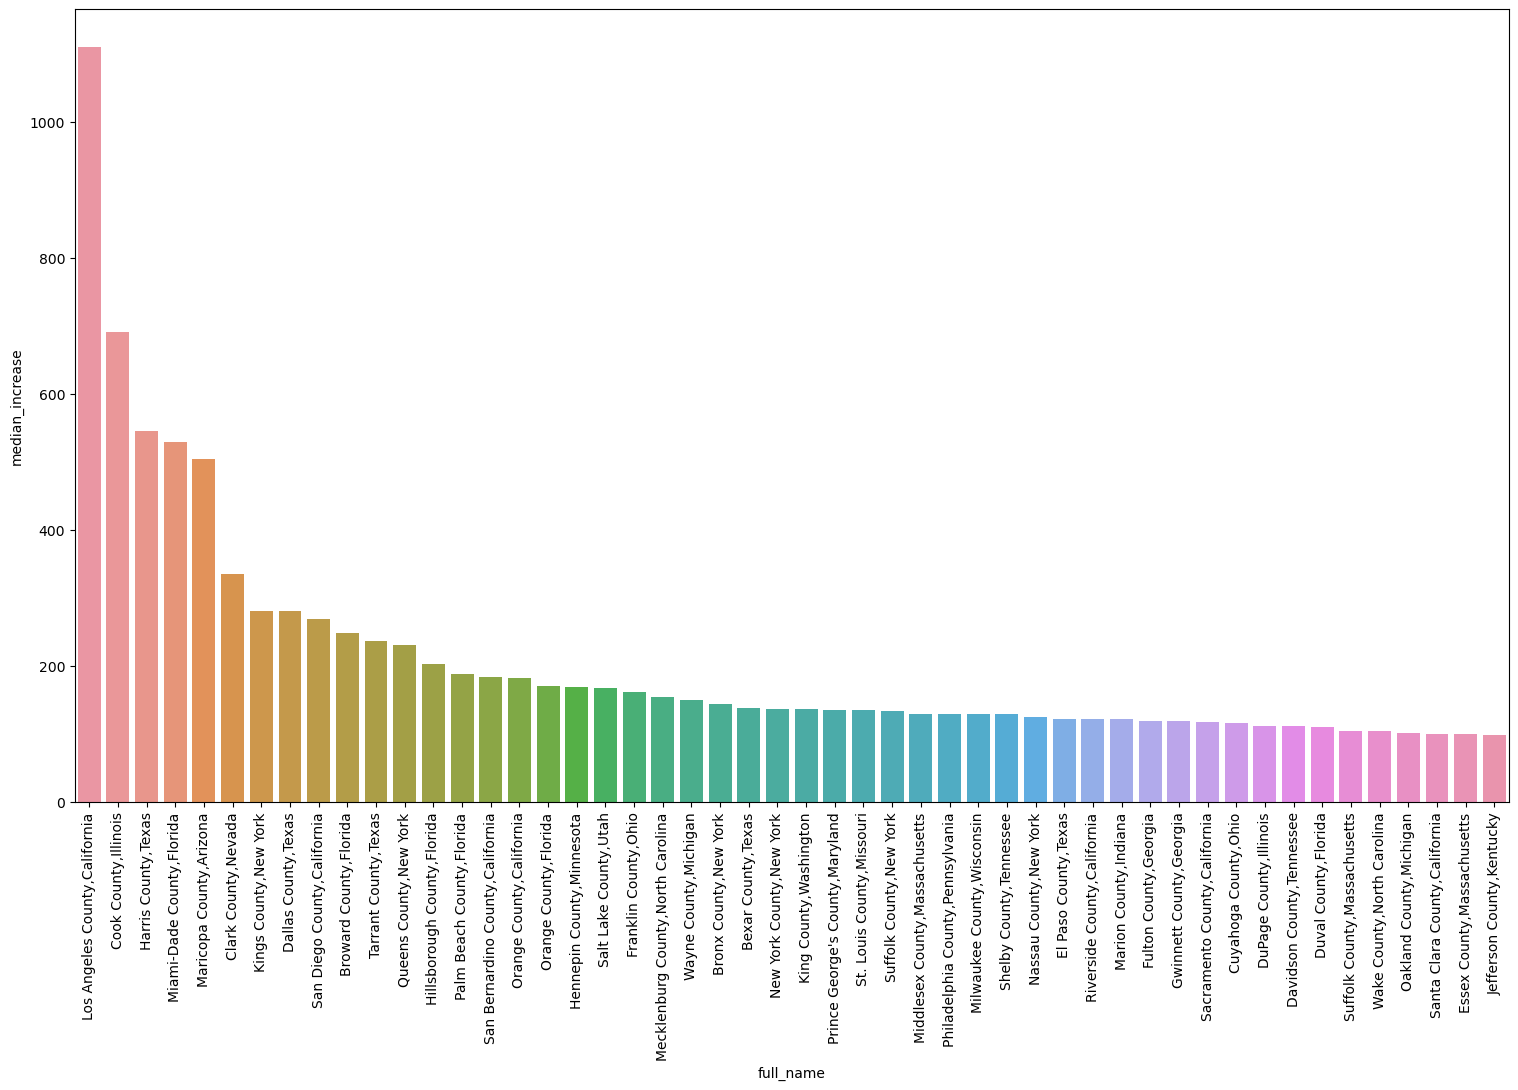

In [23]:
sns.barplot(data = top50, x = 'full_name', y = 'median_increase')
plt.xticks(rotation=90)


import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2b

Create a visualization that shows the overall county-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. For all questions that reference population, use the population estimates from 2020.
<!--
BEGIN QUESTION
name: q2b
points: 4
manual: True
-->

In [24]:
state_wise_county_data = county_data.groupby('STNAME').sum()
state_wise_county_data.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
STNAME,,,,,,,,,,,,,,,,,,,,,
Alabama,3350,201,402,67,4489,4780118,4785514,4799642,4816632,4831586,...,741318,745812,747606,628.0,71489,5.465,5.433,9.823,14.428,31.846
Alaska,1400,112,252,56,4079,700610,704308,712579,721046,727803,...,93627,93627,93627,42.0,60079,1.559,1.783,2.554,9.463,12.636
Arizona,750,60,120,60,208,6392292,6407342,6473416,6556344,6634690,...,1042480,1045835,1048600,770.0,60208,0.745,0.798,1.420,2.210,9.825
Arkansas,3750,225,525,375,5625,2916029,2921998,2941038,2952876,2960459,...,467107,468802,469894,365.0,380625,6.819,6.544,10.377,16.547,34.715
California,2900,232,522,348,3364,37254522,37319550,37636311,37944551,38253768,...,4462810,4468496,4472660,2948.0,351364,1.874,1.782,3.694,9.199,41.449


In [25]:
tmp_q2b = state_wise_county_data.copy()
tmp_q2b.loc[:, '1/22/20':'9/12/21'] = tmp_q2b.loc[:, '1/22/20':'9/12/21'].div(tmp_q2b['POPESTIMATE2020'],
                                                                              axis = 0)
tmp_q2b = tmp_q2b.T.loc['1/22/20':'9/12/21', :]
tmp_q2b.tail()

STNAME,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
9/8/21,0.148765,0.127611,0.139733,0.152629,0.112925,0.108598,0.105820,0.124355,0.079535,0.154118,...,0.151826,0.155401,0.128353,0.109143,0.047190,0.092357,0.076509,0.112988,0.128432,0.136172
9/9/21,0.149652,0.128761,0.140067,0.153423,0.113067,0.108926,0.105994,0.124712,0.079767,0.154118,...,0.152520,0.156082,0.129193,0.109567,0.047434,0.092817,0.077033,0.113965,0.128791,0.137088
9/10/21,0.150627,0.129711,0.140469,0.154134,0.113361,0.109302,0.106169,0.125369,0.079917,0.158730,...,0.153209,0.156747,0.129857,0.110019,0.047670,0.093338,0.077477,0.115298,0.129267,0.138484
9/11/21,0.151541,0.129711,0.140922,0.154693,0.113506,0.109302,0.106169,0.125995,0.079917,0.158730,...,0.153209,0.156747,0.130157,0.110019,0.047989,0.093338,0.077477,0.116566,0.129267,0.138484
9/12/21,0.151905,0.129711,0.141294,0.155054,0.113611,0.109302,0.106169,0.126533,0.079917,0.158730,...,0.153209,0.156747,0.130240,0.110019,0.048278,0.093338,0.077477,0.117823,0.129267,0.138484


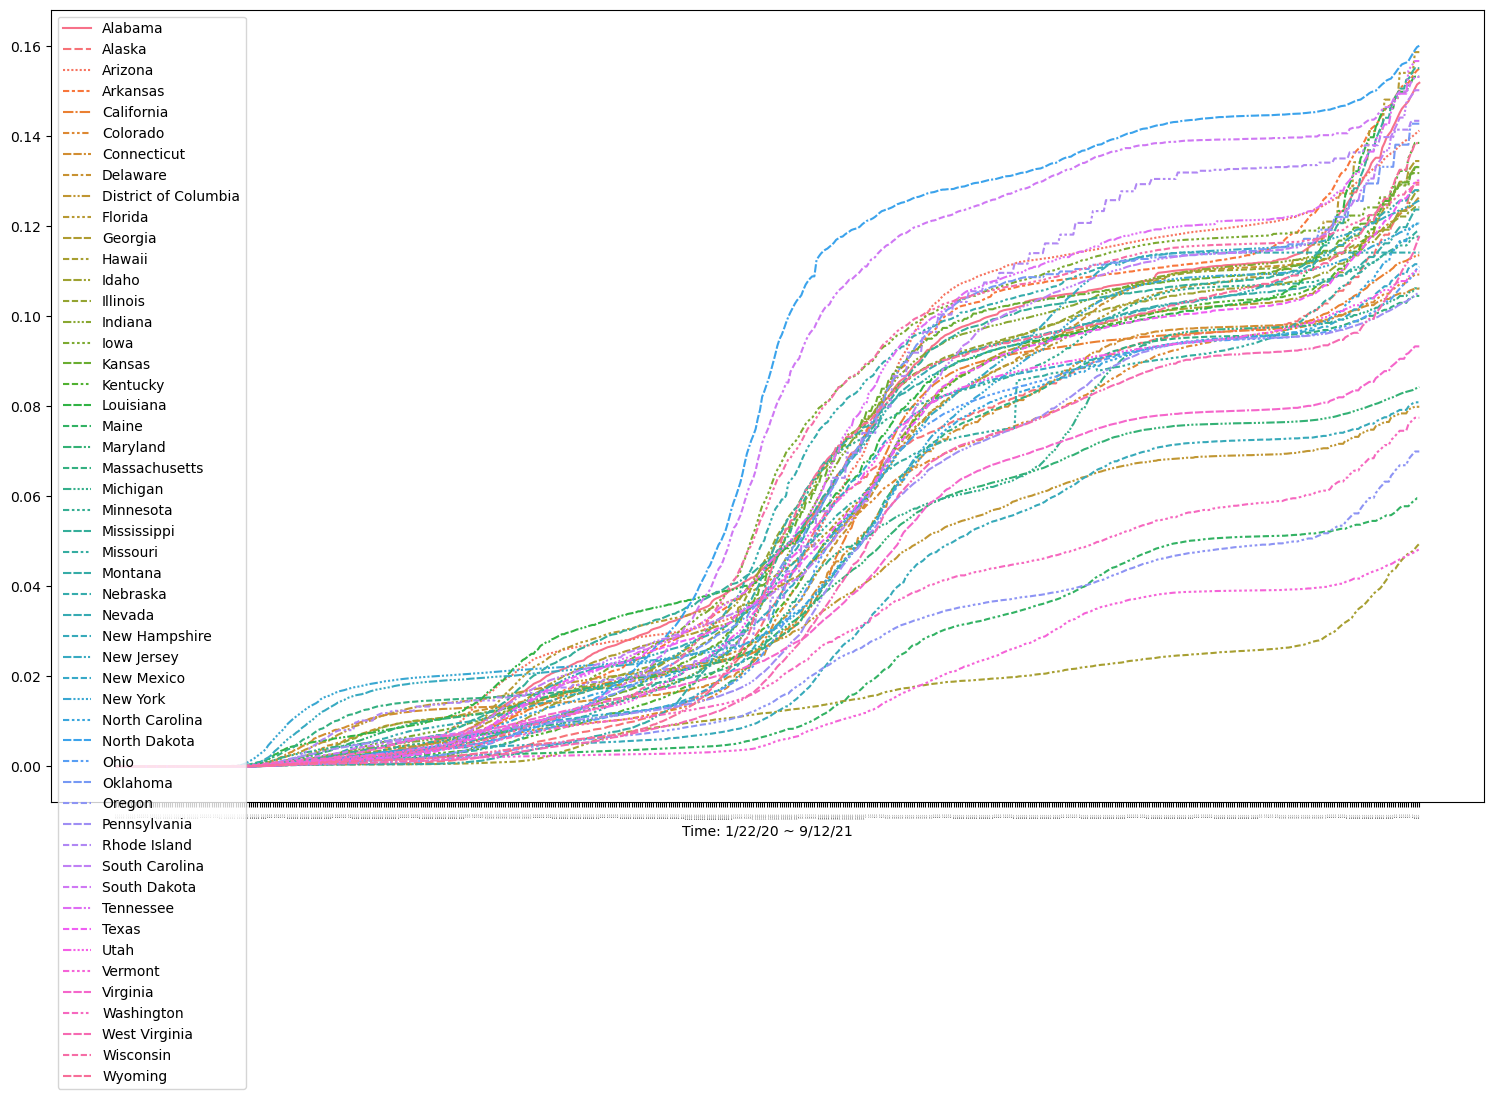

In [26]:
sns.lineplot(data = tmp_q2b)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

plt.xticks(fontsize = 0, rotation = 90)
plt.legend(loc = 'upper left')
plt.xlabel("Time: 1/22/20 ~ 9/12/21");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2c

Create a visualization that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

<!--
BEGIN QUESTION
name: q2c
points: 3
manual: True
-->

In [27]:
tmp_q2c = state_wise_county_data.loc[:, '9/3/21':'9/12/21'].copy()
tmp_q2c['Increase count'] = tmp_q2c['9/12/21'] - tmp_q2c['9/3/21']
tmp_q2c = tmp_q2c.sort_values(by = 'Increase count')
tmp_q2c = tmp_q2c.reset_index()
tmp_q2c.head()

,STNAME,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,Increase count
0,Nebraska,221235,221235,221235,221235,221235,221235,221235,221235,221235,221235,0
1,District of Columbia,55918,55918,55918,55918,56569,56694,56859,56966,56966,56966,1048
2,Vermont,28683,28864,28974,29104,29304,29416,29568,29715,29914,30094,1411
3,Rhode Island,149587,149587,149587,149587,149587,151300,151658,151658,151658,151658,2071
4,New Hampshire,108245,108245,108245,108245,109243,109757,110246,110548,110548,110548,2303


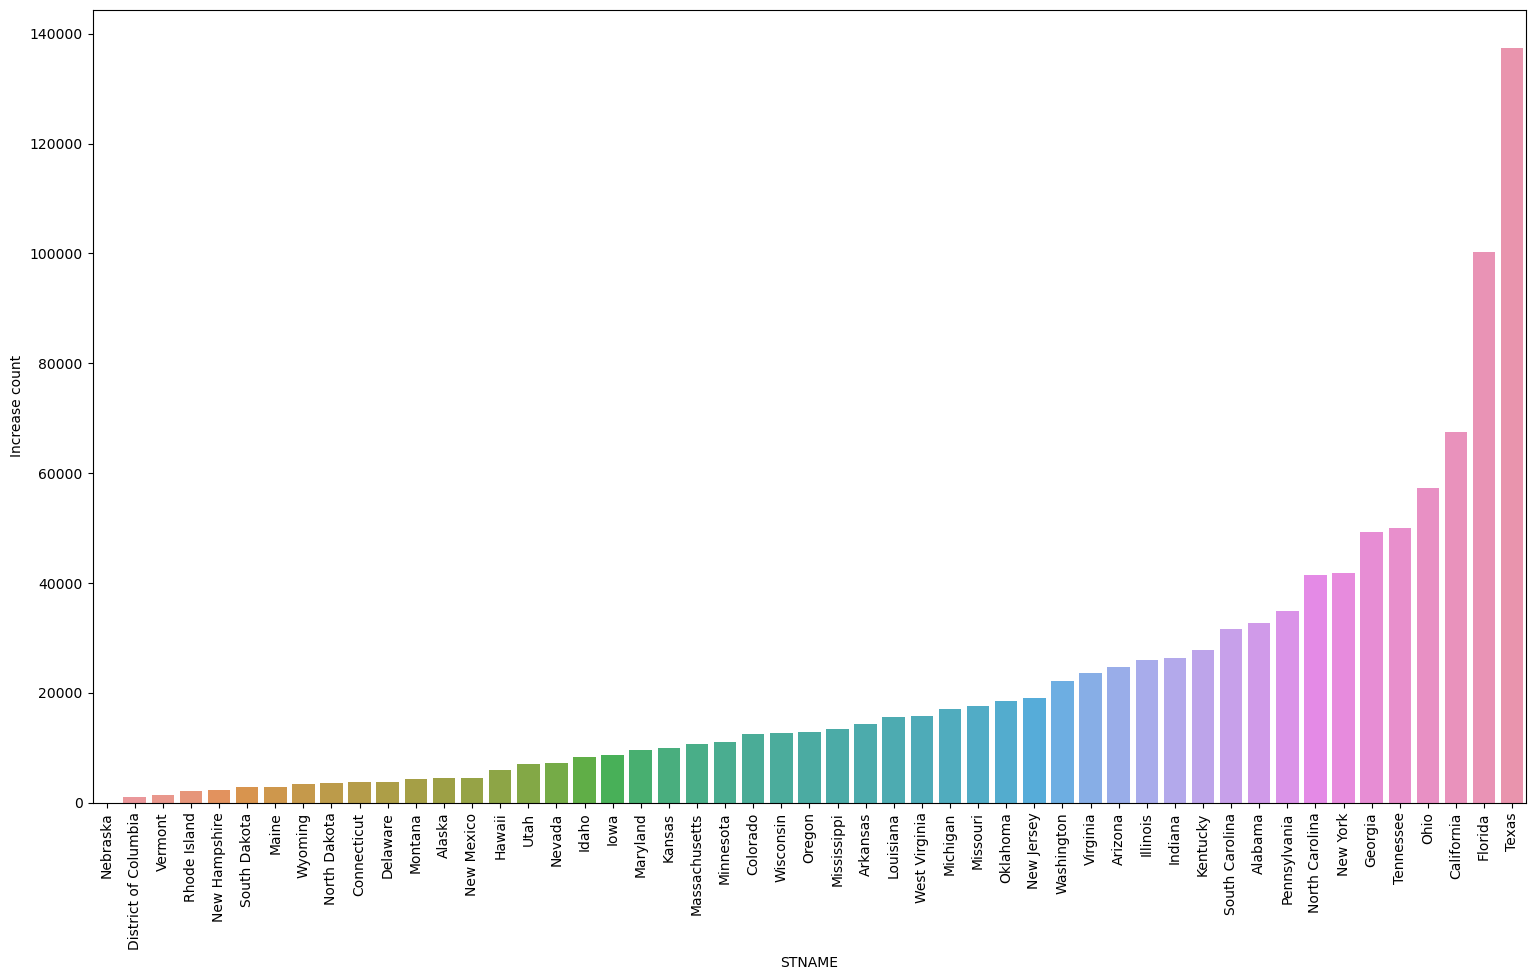

In [28]:
sns.barplot(data = tmp_q2c, x = 'STNAME', y = 'Increase count')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

plt.xticks(rotation=90);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d

Create a plot using a technique of your choice that visualizes the relationship between:

a) the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

b) the frequency of never, rarely or sometimes wearing a mask in the respective counties

*Hint*: You may find a description of the data [here](https://github.com/CSSEGISandData/COVID-19/blob/846fa9458cc2a8904d2492d14d3e6b4f399ec027/csse_covid_19_data/csse_covid_19_time_series/README.md).

<!--
BEGIN QUESTION
name: q2d
points: 3
manual: True
-->

In [29]:
# 'Cook County' appears in many state
tmp_q2d = county_data[county_data['CTYNAME'].isin(['Mobile County','Tarrant County','San Francisco County'])
                     | ((county_data['STNAME'] == 'Illinois') & (county_data['CTYNAME'] == 'Cook County'))].copy()
tmp_q2d

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
48,50,3,6,1,97,Alabama,Mobile County,412992,413139,413328,...,68382,68791,68902,51.0,1097,0.077,0.070,0.102,0.244,0.506
222,50,4,9,6,75,California,San Francisco County,805235,805184,805519,...,48404,48518,48660,46.0,6075,0.017,0.011,0.035,0.121,0.817
609,50,2,3,17,31,Illinois,Cook County,5194675,5195024,5198977,...,602648,602648,602648,691.0,17031,0.023,0.021,0.072,0.162,0.722
2741,50,3,7,48,439,Texas,Tarrant County,1809034,1811345,1818167,...,319204,319204,319204,237.0,48439,0.023,0.034,0.077,0.144,0.722


👋 **part a)** the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

In [30]:
parta_q2d = tmp_q2d.set_index('CTYNAME')
parta_q2d = parta_q2d.T.loc['1/22/20':'9/12/21', :]
parta_q2d.tail()

CTYNAME,Mobile County,San Francisco County,Cook County,Tarrant County
9/8/21,67156,48175,600122,315696
9/9/21,67486,48263,601238,317324
9/10/21,68382,48404,602648,319204
9/11/21,68791,48518,602648,319204
9/12/21,68902,48660,602648,319204


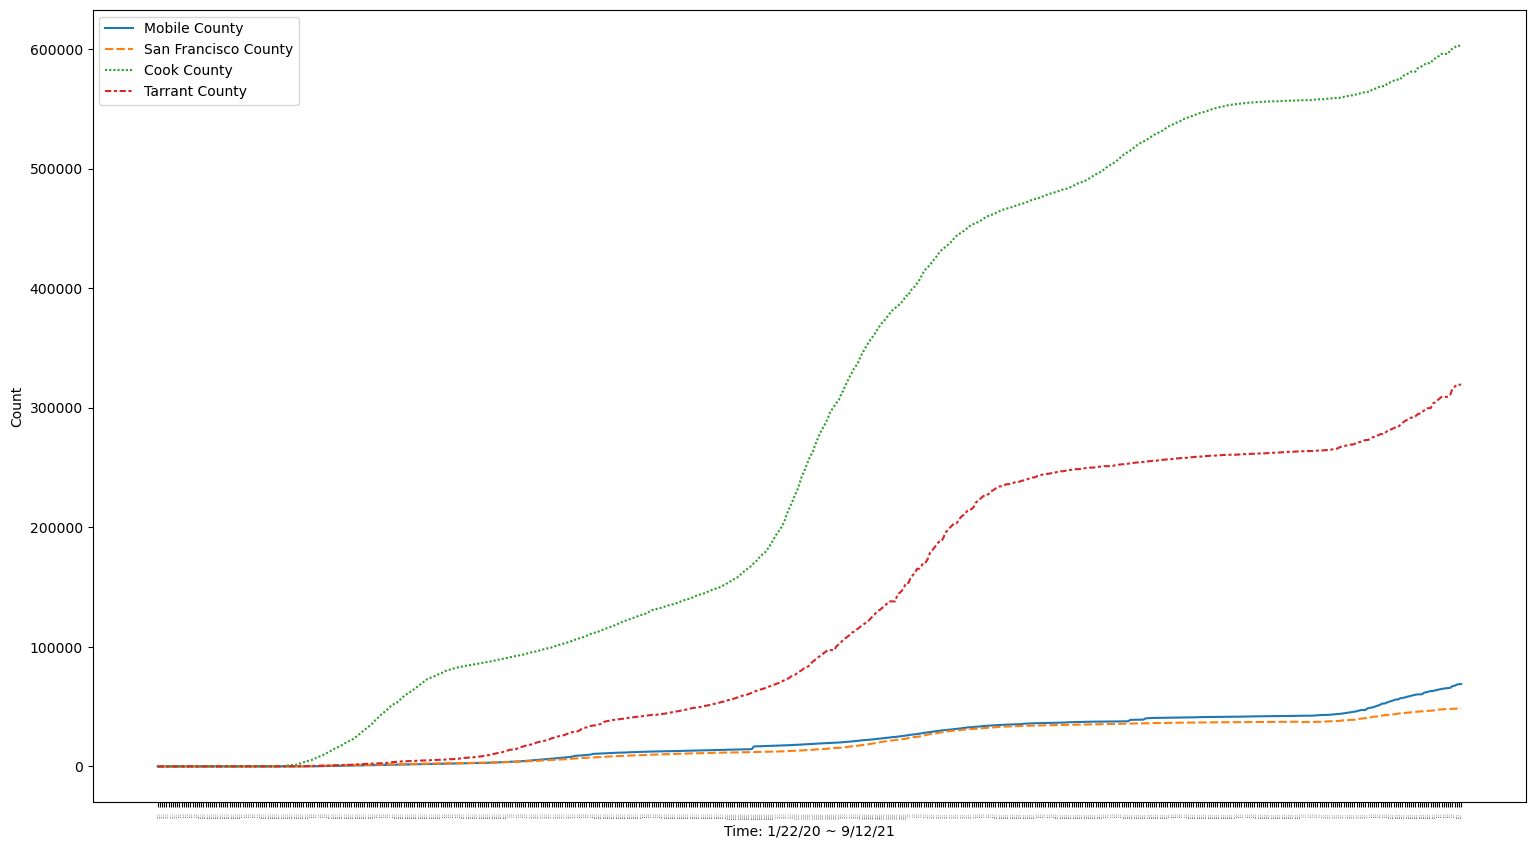

In [31]:
sns.lineplot(data = parta_q2d)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

plt.xticks(fontsize = 0, rotation = 90)
plt.legend(loc = 'upper left')
plt.ylabel("Count")
plt.xlabel("Time: 1/22/20 ~ 9/12/21");

👋 **part b)** the frequency of never, rarely or sometimes wearing a mask in the respective counties

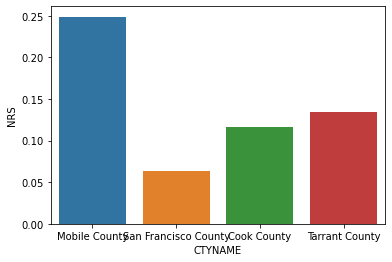

In [32]:
tmp_q2d['NRS'] = tmp_q2d['NEVER'] + tmp_q2d['RARELY'] + tmp_q2d['SOMETIMES']
sns.barplot(data = tmp_q2d, x = 'CTYNAME', y = 'NRS');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e

Visualize and describe the spatial relationship between the location and the following quantities over the continguous United States:

a) the number of most recent COVID-19 cases per capita on September 12, 2021

b) the frequency of never, rarely or sometimes wearing a mask

*Hint*: Use `plotly` to generate a heatmap on a geographical plot of the United States!

<!--
BEGIN QUESTION
name: q2e
points: 5
manual: True
-->

In [33]:
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2f

Describe and interpret the relationships in the plots above. What conclusions can be drawn about the COVID-19 dataset from these plots?

<!--
BEGIN QUESTION
name: q2f
points: 3
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 3: Guided Unsupervised Exploration


<!-- BEGIN QUESTION -->

### Question 3a

Using SVD, decompose the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data.

*Hint*: The matrix $X$ should have rows that describe location.

<!--
BEGIN QUESTION
name: q3a
points: 3
manual: True
-->

In [34]:
vaccinations.groupby('Province_State').max().head()

,FIPS,Country_Region,Date,Lat,Long_,Combined_Key,People_Fully_Vaccinated,People_Partially_Vaccinated
Province_State,,,,,,,,
Alabama,1.0,US,2021-09-26,32.3182,-86.9023,"Alabama, US",2069026.0,567613.0
Alaska,2.0,US,2021-09-26,61.3707,-152.4044,"Alaska, US",372964.0,86035.0
American Samoa,60.0,US,2021-09-26,-14.2710,-170.1320,"American Samoa, US",27875.0,8667.0
Arizona,4.0,US,2021-09-26,33.7298,-111.4312,"Arizona, US",3702564.0,964838.0
Arkansas,5.0,US,2021-09-26,34.9697,-92.3731,"Arkansas, US",1367406.0,379154.0


👋 The most recent day: 2021-09-26

In [35]:
tmp_q3a = county_data.copy()
tmp_q3a = tmp_q3a[['STATE', '9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

most_recent_vacc = vaccinations[vaccinations['Date'] == '2021-09-26'][['FIPS',
                                                                       'Province_State',
                                                                       'People_Fully_Vaccinated',
                                                                       'People_Partially_Vaccinated'
                                                                      ]]
# use 'FIPS' to join two tables
tmp_q3a = pd.merge(
    left = tmp_q3a,
    right = most_recent_vacc,
    left_on = 'STATE',
    right_on = 'FIPS'
)

# Create a new dataframe with 51 rows
X = pd.DataFrame(index = county_data['STNAME'].unique())

X['Cases per capita'] = tmp_q3a.groupby('Province_State').sum()[['9/12/21']].to_numpy()
X['Cases per capita'] /= state_wise_county_data['POPESTIMATE2020']
X[['People_Fully_Vaccinated', 'People_Partially_Vaccinated']] = (tmp_q3a
                                                                 .groupby('Province_State')
                                                                 .first()[['People_Fully_Vaccinated', 'People_Partially_Vaccinated']])
X[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']] = (tmp_q3a
                                                               .groupby('Province_State')[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
                                                               .mean())
X = (X - X.mean(axis = 0)) / X.std(axis = 0)

u, s, vt = np.linalg.svd(X, full_matrices = False)

X.head()

,Cases per capita,People_Fully_Vaccinated,People_Partially_Vaccinated,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
Alabama,1.150477,-0.350270,-0.078169,0.285379,0.191601,1.027072,0.408147,-0.511105
Alaska,0.355549,-0.748397,-0.609991,-0.335518,-0.224252,-0.422111,3.217044,-0.670420
Arizona,0.770419,0.033181,0.036478,-0.479704,-0.474527,-0.331797,-1.149766,0.680307
Arkansas,1.263254,-0.514966,-0.306495,0.509692,0.338820,0.811205,0.529175,-0.593633
California,-0.221097,4.739031,5.278886,-0.895968,-1.011352,-1.142145,-0.891600,1.075736


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b

Visualize the top 2 principal components and label the data points with the corresponding location. Color each data points based on the number of cases per capita in the location to which it corresponds.

<!--
BEGIN QUESTION
name: q3b
points: 3
manual: True
-->

In [36]:
tmp_q3a.groupby('Province_State').sum()[['9/12/21']].shape

(51, 1)

In [37]:
(X @ vt.T[:, :2]).reset_index().shape

(51, 3)

In [38]:
pcs = (X @ vt.T[:, :2])
pcs = pd.concat([pcs, tmp_q3a.groupby('Province_State').sum()[['9/12/21']]], axis = 1)
pcs = pcs.reset_index()
pcs.columns = ['State', 'Pc1', 'Pc2', 'Cases']

pcs.head()

,State,Pc1,Pc2,Cases
0,Alabama,-1.372145,-0.299742,747606
1,Alaska,-1.385786,0.566010,93627
2,Arizona,1.095759,-0.035709,1048600
3,Arkansas,-1.619365,-0.086958,469894
4,California,3.982411,-6.139417,4472660


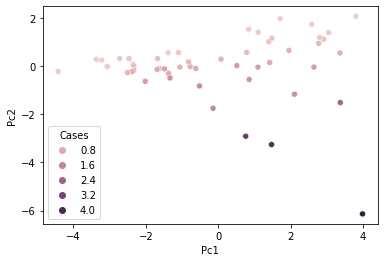

In [39]:
sns.scatterplot(data = pcs, x = 'Pc1', y = 'Pc2', hue = 'Cases');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c

What could the first and second principal component roughly represent? Interpret the visualization above and report any findings from the first two principal components given by PCA.

<!--
BEGIN QUESTION
name: q3c
points: 3
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3d

Construct a scree plot displaying the proportion of variance captured by each principal component.

<!--
BEGIN QUESTION
name: q3d
points: 3
manual: True
-->

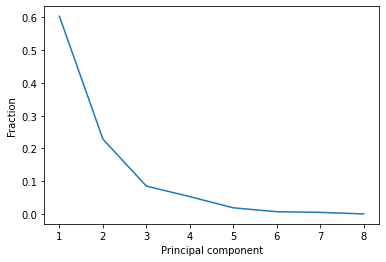

In [40]:
proportion = s ** 2 / np.sum(s ** 2)
sns.lineplot(x = np.arange(1, len(s) + 1), y = proportion)
plt.xlabel('Principal component')
plt.ylabel('Fraction');

<!-- END QUESTION -->

### Question 3e

Using the 2D representation of each state's first two principal components $x_i = [\text{PC}_1, \text{PC}_2]$, find each state's 5 closest principal component neighbors using Euclidean distance as the metric. In other words, for each state $i$ with first two principal components $x_i$, the following would be its *closest* principal component neighbor:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

Store each state's 5 closest neighbors in a Pandas DataFrame, where the index is the state's name and the columns are the 5 closest PC neighbors.

<!--
BEGIN QUESTION
name: q3e
points: 3
-->

In [41]:
state_mins = pd.DataFrame(index = pcs['State'], columns = ['1th', '2nd', '3rd', '4th', '5th'])

# matrix[i, j] = the distance between the city i and the city j
matrix = pd.DataFrame(index = pcs['State'], columns = pcs['State'])

M, N = state_mins.shape

for i in range(M):
    for j in range(i + 1, M):
        citya, cityb = pcs['State'][i], pcs['State'][j]
        left = pcs[pcs['State'] == citya][['Pc1', 'Pc2']].to_numpy()
        right = pcs[pcs['State'] == cityb][['Pc1', 'Pc2']].to_numpy()
        matrix.iloc[i, j] = np.linalg.norm(left - right, ord = 2)
        #print(np.linalg.norm(left - right, ord = 2))
        
matrix = matrix.T
        
for i in range(M):
    state_mins.iloc[i, :] = matrix.iloc[:, i].sort_values().index[:5]
    
state_mins.head()

,1th,2nd,3rd,4th,5th
State,,,,,
Alabama,Ohio,Indiana,Arkansas,Wisconsin,Kentucky
Alaska,West Virginia,Utah,Indiana,Kentucky,Mississippi
Arizona,Virginia,North Carolina,Michigan,Nevada,Colorado
Arkansas,Wisconsin,Indiana,Utah,Ohio,Kentucky
California,Texas,Florida,New York,Pennsylvania,Illinois


In [42]:
grader.check("q3e")

q3e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3f

Investigate the principal component neighbors for two states of your choice, and remark on any observations you have about their COVID-19 statistics given in the dataset, geographical or political ties. 

Compare these neighbors with the rankings from the visualization from Question 2c that depicted recent greatest increases in cases across states.

<!--
BEGIN QUESTION
name: q3f
points: 3
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Question 3g

We will investigate the relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states. 

For the sake of simplicity, may assume that the singular geographical location of a state is given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, calculate the geographical distance and the Euclidean distance between their top 2 principal components between them. Plot the relationship where the x-axis represents the top 2 principal component distance and the y-axis represents geographical distance.

*Hint*: `geopy` has a function that can calculate distance between two pairs of latitude and longitude!

*Hint*: You should be plotting 1,275 points.

<!--
BEGIN QUESTION
name: q3g
points: 3
-->

In [43]:
x, y = ..., ...

...

Ellipsis

### Question 3h

Interpret the relationship displayed in part (g). What does this suggest about the role that geography plays within this dataset despite no geographical information explicitly encoded within the matrix  $X$ from part (a)?

<!--
BEGIN QUESTION
name: q3h
points: 3
-->

_Type your answer here, replacing this text._

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

<br/><br/><br/>

## Question 4: Open EDA

Perform EDA of your choice on the data to generate 2 visualizations. You may follow the line of investigation in the guided sections by visualizing the relationship between safety protocols and the spread of COVID-19 spatially or temporally, or you may explore other areas of your choice. 

For each visualization, make sure to address the following:

1. Address a relationship in the data concerning the spread, effect, or prevention of COVID-19 through a visualization, with at *most* one univariate data visualization. If needed, use an unsupervised learning technique such as PCA to reveal patterns within the data.
2. Comment on the visualization in terms of the distribution, trends, and patterns it shows.
3. Comment on what the visualization indicates about the data with regards to the features you may choose for a supervised learning task.

<!--
BEGIN QUESTION
name: q4
points: 30
manual: True
-->

In [44]:
# YOUR CODE HERE

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [45]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q3e results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [46]:
# Save your notebook first, then run this cell to export your submission.
grader.export()